# **Phishing Website Detection using Neural Networks and Logistic Regression**

**A CS 180 Machine Learning Project**

## **Main Objective**

In the digital age, the Internet is essential for communication and commerce but also brings security threats, with phishing being a major concern. Phishing tricks people into giving up sensitive information by posing as legitimate entities, leading to financial loss and identity theft (Dutta, 2021). The main challenge in fighting phishing is its evolving nature, as cybercriminals constantly update their tactics, outpacing traditional methods like blacklists (Almenari & Alshammari, 2023).

Machine Learning (ML) offers a promising solution by analyzing various website characteristics—such as URL length, HTTPS usage, and PageRank—to predict phishing attempts. This approach is necessary given the limitations of current security measures (Dutta, 2021). Our project stands out by using a diverse set of features to train ML models, improving prediction accuracy. For example, a short URL may not be suspicious alone, but combined with a low PageRank and no HTTPS, it could indicate a phishing site (Almenari & Alshammari, 2023).

This project has practical implications for enhancing online security, offering real-time warnings about potential phishing sites and aiding cybersecurity professionals in identifying threats more efficiently (Dutta, 2021). In summary, using ML to detect phishing websites based on various characteristics is a novel, challenging, and valuable endeavor to make the Internet safer for all users.

## **Preliminaries**


Let's import important libraries for this project.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


Let's also import the dataset that will be used. 

Note that this dataset was constructed via `dataset-construction.ipynb`. The notebook simply combined the files that were found in the original dataset on Kaggle, which was made by Hemanth Pingali. The dataset can be found [here](https://www.kaggle.com/datasets/hemanthpingali/phishing-url/data). 

In [3]:
df_url = pd.read_csv('./datasets/final_dataset.csv')
df_url.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,https://www.todayshomeowner.com/how-to-make-ho...,82,23,0,2,7,0,0,0,0,...,1,1,0,240,8892,67860,0,1,4,legitimate
1,http://thapthan.ac.th/information/confirmation...,93,14,1,2,0,0,0,0,0,...,1,0,1,0,2996,4189860,0,1,2,phishing
2,http://app.dialoginsight.com/T/OFC4/L2S/3888/B...,121,21,1,3,0,0,0,0,0,...,1,1,0,30,2527,346022,0,1,3,phishing
3,https://www.bedslide.com,24,16,0,2,0,0,0,0,0,...,0,0,0,139,7531,1059151,0,0,4,legitimate
4,https://tabs.ultimate-guitar.com/s/sex_pistols...,73,24,0,3,1,0,0,0,0,...,0,0,0,3002,7590,635,0,1,5,legitimate


## **Data Preprocessing**

First, let's evaluate the dataframe.

In [4]:
# Determine the shape of the dataframe
df_url.shape

(11430, 89)

In [5]:
# Determine its columns
df_url.columns

Index(['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens',
       'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore',
       'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
       'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com',
       'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'punycode', 'port', 'tld_in_path',
       'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains',
       'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statistical_report', 

This indicates that the dataframe has `89 columns` and `11430 rows`. Each column represents a feature associated with each URL. Now let's perform some exploration with the dataframe. First, let's see if there are null values within the dataset.

In [6]:
df_url.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

Fortunately, there are no null values. However, those are a lot of features. Each column contains an `int` or `float` except for `URL` and `status`, which are both strings. The `URL` column can be dropped while the `status` column will retain. 

But before that, let's try to reduce the number of columns by checking if they only have one unique value.

In [7]:
lst_removed_features = []
for feature in df_url.columns:
    if len(df_url[feature].unique()) == 1:
        lst_removed_features.append(feature)
        df_url.drop([feature], axis=1, inplace=True)
print(lst_removed_features)
df_url.shape

['nb_or', 'ratio_nullHyperlinks', 'ratio_intRedirection', 'ratio_intErrors', 'submit_email', 'sfh']


(11430, 83)

6 features only have one unique value. Now, we have 83 columns left. Let's now drop the `URL` column. 


In [8]:
df_url.drop(['url'], axis=1, inplace=True)
df_url.shape

(11430, 82)

Next, let's convert the `status` column. We shall label `phishing` as `1` and `legitimate` as `-1`.

In [9]:
print(df_url['status'].iloc[0])
df_url['status'] = np.where(df_url['status'] == 'legitimate', -1, 1)
print(df_url['status'].iloc[0])

legitimate
-1


Let's confirm if all columns are now either an `int` or a `float` 

In [10]:
df_url.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 82 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   length_url                  11430 non-null  int64  
 1   length_hostname             11430 non-null  int64  
 2   ip                          11430 non-null  int64  
 3   nb_dots                     11430 non-null  int64  
 4   nb_hyphens                  11430 non-null  int64  
 5   nb_at                       11430 non-null  int64  
 6   nb_qm                       11430 non-null  int64  
 7   nb_and                      11430 non-null  int64  
 8   nb_eq                       11430 non-null  int64  
 9   nb_underscore               11430 non-null  int64  
 10  nb_tilde                    11430 non-null  int64  
 11  nb_percent                  11430 non-null  int64  
 12  nb_slash                    11430 non-null  int64  
 13  nb_star                     114

Great! Every column is now either an `int` or a `float`. Let's also determine the number of 'good' and 'bad' URLs in the dataframe.

In [11]:
print(df_url['status'].value_counts())

status
-1    5715
 1    5715
Name: count, dtype: int64


The dataset has equal number of `good` and `bad` URLs. Now, let's examine the unique values of each feature. 



In [12]:
for feature in df_url.columns:
    print(f"{feature}: {sorted(df_url[feature].unique())}")

length_url: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 181, 183, 185, 186, 187, 188, 189, 190, 192, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 225, 226, 227, 228, 229, 230, 231, 232, 234, 235, 236, 237, 

A majority of the data contains only 0s and 1s. Let's see quickly see which features greatly influence the results.

In [13]:
for feature in df_url.columns:
    if np.array_equal(df_url[feature].unique(), np.array([0, 1])) or np.array_equal(df_url[feature].unique(), np.array([1, 0])):
        print(feature)
        print(f'Number of Good URLs tagged as 0: {len(df_url[(df_url[feature] == 0) & (df_url["status"] == -1)])}')
        print(f'Number of Good URLs tagged as 1: {len(df_url[(df_url[feature] == 1) & (df_url["status"] == -1)])}')
        print(f'Number of Bad URLs tagged as 0: {len(df_url[(df_url[feature] == 0) & (df_url["status"] == 1)])}')
        print(f'Number of Bad URLs tagged as 1: {len(df_url[(df_url[feature] == 1) & (df_url["status"] == 1)])}')
        print()

ip
Number of Good URLs tagged as 0: 5512
Number of Good URLs tagged as 1: 203
Number of Bad URLs tagged as 0: 4197
Number of Bad URLs tagged as 1: 1518

nb_tilde
Number of Good URLs tagged as 0: 5691
Number of Good URLs tagged as 1: 24
Number of Bad URLs tagged as 0: 5663
Number of Bad URLs tagged as 1: 52

nb_star
Number of Good URLs tagged as 0: 5715
Number of Good URLs tagged as 1: 0
Number of Bad URLs tagged as 0: 5707
Number of Bad URLs tagged as 1: 8

nb_dslash
Number of Good URLs tagged as 0: 5711
Number of Good URLs tagged as 1: 4
Number of Bad URLs tagged as 0: 5644
Number of Bad URLs tagged as 1: 71

https_token
Number of Good URLs tagged as 0: 2543
Number of Good URLs tagged as 1: 3172
Number of Bad URLs tagged as 0: 1904
Number of Bad URLs tagged as 1: 3811

punycode
Number of Good URLs tagged as 0: 5715
Number of Good URLs tagged as 1: 0
Number of Bad URLs tagged as 0: 5711
Number of Bad URLs tagged as 1: 4

port
Number of Good URLs tagged as 0: 5704
Number of Good URLs ta

Looks like `external_favicon` and `google_index` are good indicators of whether or not a URL is good or bad. We shall see later. 

But before that, it looks like there are some outliers within the data. Let's confirm it by visualizing a portion of the data and getting its mean and standard deviation.

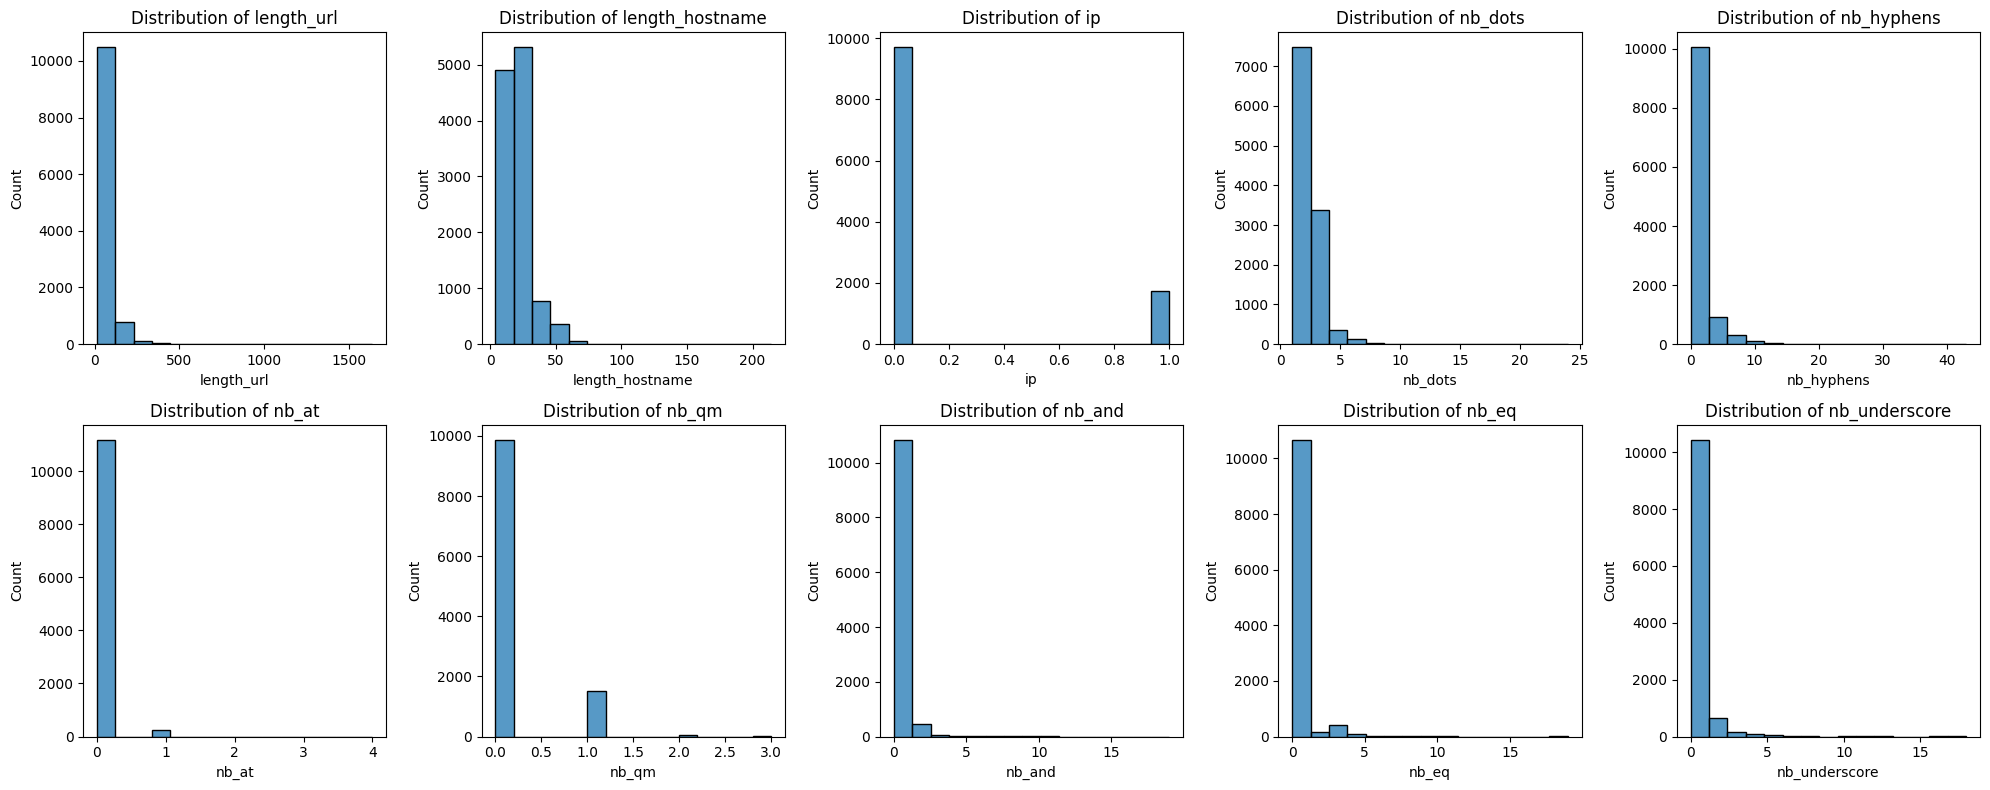

In [14]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, feature in enumerate(df_url.columns[0:10]):
    row = i // 5  
    col = i % 5
    sns.histplot(df_url[feature], bins=15, ax=axs[row, col])
    axs[row, col].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [15]:
for feature in df_url.columns[0:10]:
    print(feature)
    print(f"Mean:  {df_url[feature].mean()}")
    print(f"Std Deviation: {df_url[feature].std()}")
    print()


length_url
Mean:  61.12668416447944
Std Deviation: 55.29731803500547

length_hostname
Mean:  21.090288713910763
Std Deviation: 10.777171075983661

ip
Mean:  0.15056867891513562
Std Deviation: 0.3576435970047892

nb_dots
Mean:  2.4807524059492563
Std Deviation: 1.3696862349823724

nb_hyphens
Mean:  0.9975503062117236
Std Deviation: 2.0870866419127916

nb_at
Mean:  0.022222222222222223
Std Deviation: 0.15549985322645118

nb_qm
Mean:  0.14120734908136484
Std Deviation: 0.36445577382663175

nb_and
Mean:  0.16229221347331582
Std Deviation: 0.8213374140891005

nb_eq
Mean:  0.2931758530183727
Std Deviation: 0.9983172347996663

nb_underscore
Mean:  0.3226596675415573
Std Deviation: 1.0933356750905225



The data is not well-distributed. Let's standardize it.

In [16]:
scaler = StandardScaler()
df_url_scaled = scaler.fit_transform(df_url)
df_url = pd.DataFrame(df_url_scaled, columns=df_url.columns)


Let's see if they're now well-distributed.

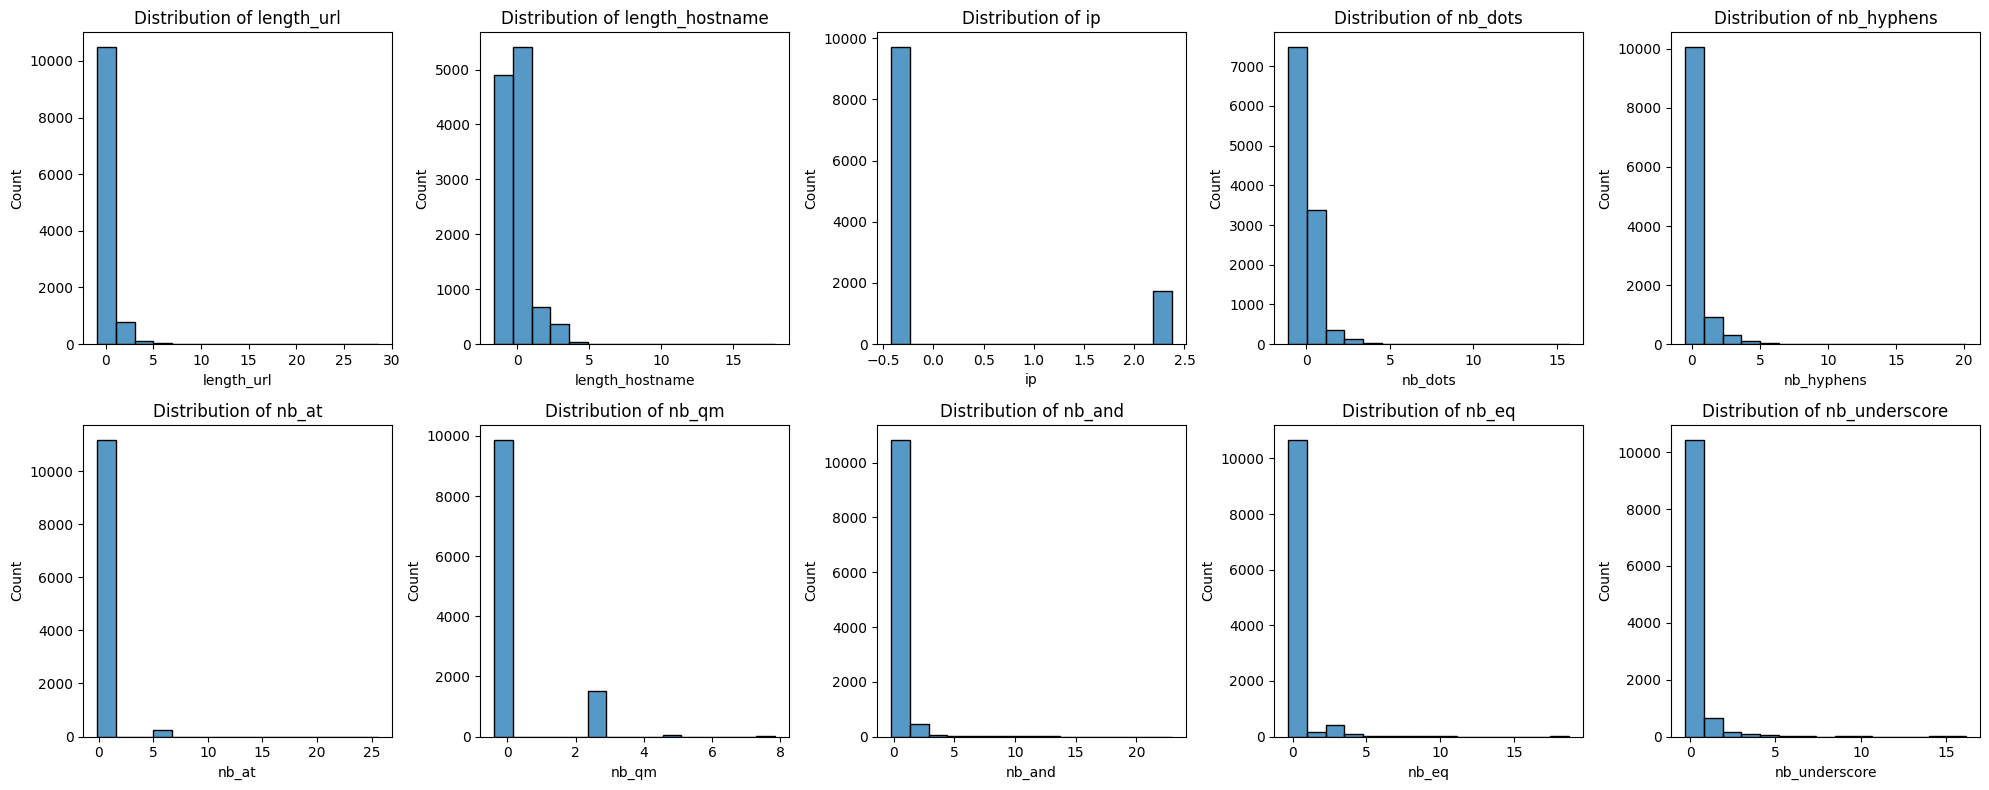

In [17]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, feature in enumerate(df_url.columns[0:10]):
    row = i // 5  
    col = i % 5
    sns.histplot(df_url[feature], bins=15, ax=axs[row, col])
    axs[row, col].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [18]:
for feature in df_url.columns[0:10]:
    print(feature)
    print(f"Mean:  {df_url[feature].mean()}")
    print(f"Std Deviation: {df_url[feature].std()}")
    print()


length_url
Mean:  -5.15967165950029e-17
Std Deviation: 1.0000437474025188

length_hostname
Mean:  -1.3800567571193547e-16
Std Deviation: 1.000043747402519

ip
Mean:  -2.4865887515664047e-18
Std Deviation: 1.000043747402519

nb_dots
Mean:  4.4758597528195287e-17
Std Deviation: 1.000043747402519

nb_hyphens
Mean:  4.196118518268308e-18
Std Deviation: 1.000043747402519

nb_at
Mean:  1.4297885321506827e-17
Std Deviation: 1.0000437474025188

nb_qm
Mean:  -1.491953250939843e-17
Std Deviation: 1.0000437474025188

nb_and
Mean:  2.2379298764097643e-17
Std Deviation: 1.000043747402519

nb_eq
Mean:  2.1757651576206043e-18
Std Deviation: 1.000043747402519

nb_underscore
Mean:  4.102871440084568e-17
Std Deviation: 1.000043747402519



Now, the data is properly scaled and well-distributed since they have a standard deviation of 1. This will be helpful when building the models using Neural Networks and Logistic Regression. 

## **Data Modelling**

Before we proceed, let's once again check the first few rows of our dataframe.

In [19]:
df_url.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_eq,nb_underscore,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,0.377491,0.177207,-0.421020,-0.351010,2.876120,-0.142915,-0.387464,-0.197604,-0.293683,-0.295128,...,0.537498,1.129194,-0.28037,-0.309957,1.554055,-0.395334,-0.143303,0.934264,0.320974,-1.0
1,0.576424,-0.657928,2.375182,-0.351010,-0.477984,-0.142915,-0.387464,-0.197604,-0.293683,-0.295128,...,0.537498,-0.885587,3.56672,-0.604531,-0.343200,1.670294,-0.143303,0.934264,-0.467407,1.0
2,1.082800,-0.008378,2.375182,0.379116,-0.477984,-0.142915,-0.387464,-0.197604,-0.293683,-0.295128,...,0.537498,1.129194,-0.28037,-0.567710,-0.494118,-0.255941,-0.143303,0.934264,-0.073217,1.0
3,-0.671431,-0.472342,-0.421020,-0.351010,-0.477984,-0.142915,-0.387464,-0.197604,-0.293683,-0.295128,...,-1.860473,-0.885587,-0.28037,-0.433924,1.116103,0.101424,-0.143303,-1.070361,0.320974,-1.0
4,0.214727,0.270000,-0.421020,0.379116,0.001174,-0.142915,-0.387464,-0.197604,-0.293683,4.278233,...,-1.860473,-0.885587,-0.28037,3.080108,1.135089,-0.429022,-0.143303,0.934264,0.715164,-1.0


Now, let's randomize the rows before we split the data.

In [20]:
df_url = df_url.sample(frac=1).reset_index(drop=True)
df_url.head(10)

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_eq,nb_underscore,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,-0.219309,-1.121892,-0.421020,0.379116,-0.477984,-0.142915,-0.387464,-0.197604,-0.293683,-0.295128,...,0.537498,-0.885587,-0.28037,0.466984,1.115138,-0.429340,-0.143303,0.934264,-1.255788,1.0
1,-0.345903,-0.193964,-0.421020,-0.351010,-0.477984,-0.142915,-0.387464,-0.197604,-0.293683,-0.295128,...,-1.860473,1.129194,-0.28037,0.678096,1.177243,-0.428593,-0.143303,-1.070361,0.715164,-1.0
2,0.757273,-0.565135,2.375182,-1.081136,0.001174,-0.142915,-0.387464,-0.197604,-0.293683,-0.295128,...,0.537498,1.129194,-0.28037,-0.427787,-0.648253,-0.429340,-0.143303,0.934264,-1.255788,1.0
3,-0.508667,0.362793,-0.421020,0.379116,-0.477984,-0.142915,-0.387464,-0.197604,-0.293683,-0.295128,...,0.537498,1.129194,-0.28037,-0.355370,0.273022,-0.429340,-0.143303,-1.070361,0.320974,-1.0
4,-0.345903,-0.565135,-0.421020,-0.351010,-0.477984,-0.142915,-0.387464,-0.197604,-0.293683,-0.295128,...,-1.860473,-0.885587,-0.28037,-0.108664,1.030830,-0.428788,-0.143303,0.934264,1.503545,-1.0
5,0.395576,-0.379549,-0.421020,1.109242,-0.477984,6.288241,2.356473,-0.197604,0.708047,-0.295128,...,0.537498,1.129194,-0.28037,-0.319776,-1.264475,-0.429340,-0.143303,0.934264,-1.255788,1.0
6,-0.291649,-0.008378,-0.421020,-0.351010,0.001174,-0.142915,-0.387464,-0.197604,-0.293683,-0.295128,...,0.537498,1.129194,-0.28037,1.283202,0.430697,-0.382861,-0.143303,-1.070361,0.715164,-1.0
7,-0.599091,-0.101171,-0.421020,-0.351010,-0.477984,-0.142915,-0.387464,-0.197604,-0.293683,-0.295128,...,0.537498,1.129194,-0.28037,-0.023974,-0.166860,-0.429340,-0.143303,-1.070361,-0.467407,-1.0
8,-0.418243,-0.193964,-0.421020,-0.351010,0.001174,-0.142915,-0.387464,-0.197604,-0.293683,-0.295128,...,0.537498,1.129194,-0.28037,-0.436378,0.646938,-0.422119,-0.143303,-1.070361,0.715164,-1.0
9,-0.671431,-0.472342,-0.421020,-0.351010,-0.477984,-0.142915,-0.387464,-0.197604,-0.293683,-0.295128,...,-1.860473,-0.885587,-0.28037,-0.294001,-0.566198,-0.429340,-0.143303,-1.070361,-1.255788,1.0


We can see that the rows has been randomized. Now, let's split the dataset used for training and testing. 

In [21]:
X = df_url.drop('status', axis=1)
y = df_url['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of y_test: {len(y_test)}")

Length of X_train: 9144
Length of X_test: 2286
Length of y_train: 9144
Length of y_test: 2286


Data modelling can now proceed. Let's model our data using `MLPClassifier`.

In [22]:
mlp = MLPClassifier(hidden_layer_sizes=(200, 200, 200), activation='tanh', max_iter=10000, alpha=0.0001, solver='adam', random_state=42, tol=0.00001)
mlp_model = mlp.fit(X_train, y_train)
print(f"Training score: {mlp_model.score(X_train, y_train) * 100:.2f}%")
print(f"Testing score: {mlp_model.score(X_test, y_test) * 100:.2f}%")

Training score: 100.00%
Testing score: 96.28%


Wow! `MLPClassifier` displayed great results in both training and testing sets. What about `LogisticRegression`?

In [27]:
lr = LogisticRegression(max_iter=1000000, random_state=42, tol=0.0001)
lr_model = lr.fit(X_train, y_train)
print(f"Training score: {lr.score(X_train, y_train) * 100:.2f}%")
print(f"Testing score: {lr.score(X_test, y_test) * 100:.2f}%")

Training score: 94.87%
Testing score: 94.53%


`LogisticRegression` performed relatively well. Since `MLPClassifier` performed better than `LogisticRegression`, let's try to see if we can get better results. 

## **Hyperparameter Tuning using `GridSearchCV`**

### **`MLPClassifier`**

Let's define first the parameters to be used to tune the model.

In [28]:
param_grid = {
    'hidden_layer_sizes': [(100, 100, 100), (200, 200, 200), (300, 300, 300)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'max_iter':[10000], 
    'alpha': [0.0001], 
    'solver': ['adam'], 
    'random_state': [42],
    'tol': [0.00001]
}

We can now proceed to improving the model!

In [29]:
mlp_model = MLPClassifier()
grid_search = GridSearchCV(mlp_model, param_grid, cv=4, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")